In [1]:
import cv2
import random
# from resnet import classify
import numpy as np
from PIL import Image, ImageOps 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.autograd import Variable
import torch
import argparse
import imutils
from imutils import contours
from skimage import measure
import os

GPU_NUM = 7 # GPU Num
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset_imagenet', type=str, default='/mnt/data/approx-killer/Advlight-main/query_imagenet', help='location of the data corpus')
parser.add_argument('--adv_imagenet', type=str, default='/mnt/data/approx-killer/Advlight-main/AdvLS-main/results1_std', help='dir to save results')
parser.add_argument('--dataset_neurips', type=str, default='/mnt/data/approx-killer/optical_adversarial_attack-main/archive/images', help='location of the data corpus')
parser.add_argument('--adv_neurips', type=str, default='/mnt/data/approx-killer/Advlight-main/AdvLS-main/results2_1_50', help='dir to save results')

args, unknown = parser.parse_known_args()

# Mask generation process visualization

In [3]:
pic_path = '199_ori.jpg'
adv_path = '199_adv.jpg'
img = Image.open(pic_path.encode("utf-8")).convert('RGB')
adv = Image.open(adv_path.encode("utf-8")).convert('RGB')
transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.RandomAutocontrast(p=1),
    #transforms.ToTensor()
])
img_transformed = transform(img)
adv_transformed = transform(adv)

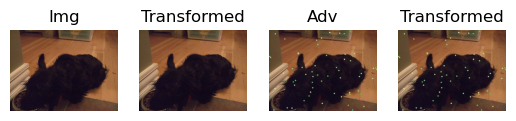

In [4]:
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Img')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_transformed)
plt.title('Transformed')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(adv)
plt.title('Adv')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(adv_transformed)
plt.title('Transformed')
plt.axis('off')

plt.show()

In [8]:
adv = np.array(adv_transformed)
# Grayscale map
gray = cv2.cvtColor(adv, cv2.COLOR_BGR2GRAY)
# Gaussian blurr
blurred = cv2.GaussianBlur(gray, (11, 11), 0)
# grayscale filter
thresh = cv2.threshold(blurred, 140, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.dilate(thresh, None, iterations=3)


img = np.array(img_transformed)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred_img = cv2.GaussianBlur(gray_img, (11, 11), 0)
thresh_img = cv2.threshold(blurred_img, 140, 255, cv2.THRESH_BINARY)[1]
thresh_img = cv2.dilate(thresh_img, None, iterations=3)

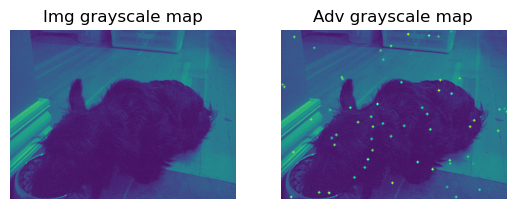

In [37]:
plt.subplot(1, 2, 1)
plt.imshow(gray_img)
plt.title('Img grayscale map')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray)
plt.title('Adv grayscale map')
plt.axis('off')
plt.show()

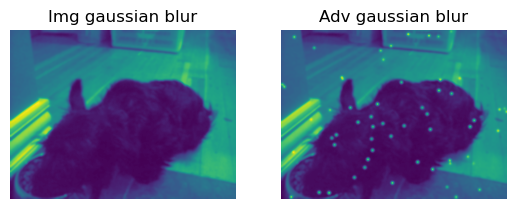

In [36]:
plt.subplot(1, 2, 1)
plt.imshow(blurred_img)
plt.title('Img gaussian blur')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blurred)
plt.title('Adv gaussian blur')
plt.axis('off')
plt.show()

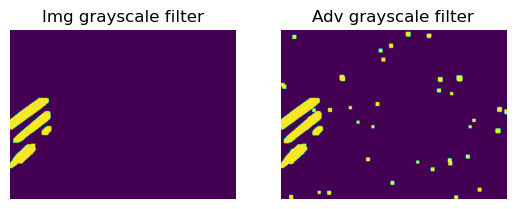

In [34]:
plt.subplot(1, 2, 1)
plt.imshow(thresh_img)
plt.title('Img grayscale filter')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thresh)
plt.title('Adv grayscale filter')
plt.axis('off')
plt.show()

In [23]:
labels = measure.label(thresh, connectivity=2, background=0)
mask = np.zeros(thresh.shape, dtype="uint8")
# loop over the unique components
for label in np.unique(labels):
  # if this is the background label, ignore it
  if label == 0:
    continue
  # count number of pixels 
  labelMask = np.zeros(thresh.shape, dtype="uint8")
  labelMask[labels == label] = 255
  numPixels = cv2.countNonZero(labelMask)
  if numPixels < 200:
    mask = cv2.add(mask, labelMask)

labels_img = measure.label(thresh_img, connectivity=2, background=0)
mask_img = np.zeros(thresh_img.shape, dtype="uint8")
# loop over the unique components
for label in np.unique(labels_img):
  # if this is the background label, ignore it
  if label == 0:
    continue

  #count number of pixels 
  labelMask = np.zeros(thresh_img.shape, dtype="uint8")
  labelMask[labels_img == label] = 255
  numPixels = cv2.countNonZero(labelMask)

  if numPixels < 200:
    mask_img = cv2.add(mask_img, labelMask)

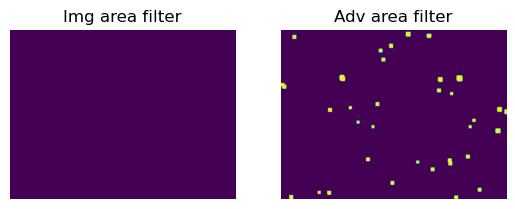

In [35]:
plt.subplot(1, 2, 1)
plt.imshow(mask_img)
plt.title('Img area filter')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Adv area filter')
plt.axis('off')
plt.show()

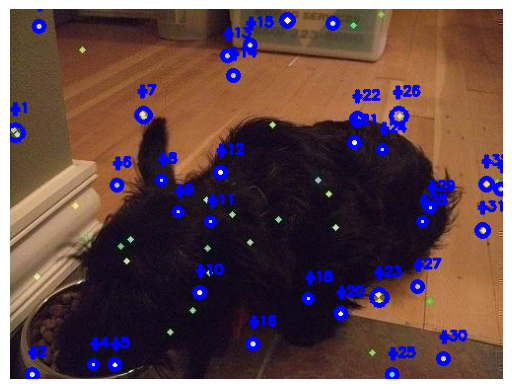

In [33]:
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
  cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]
n = len(cnts)
for (i, c) in enumerate(cnts):
  
  (x, y, w, h) = cv2.boundingRect(c)
  ((cX, cY), radius) = cv2.minEnclosingCircle(c)
  cv2.circle(adv, (int(cX), int(cY)), int(radius),
    (0, 0, 255), 3)
  cv2.putText(adv, "#{}".format(i + 1), (x, y - 15),
    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
  
# show the output image

imgplot = plt.imshow(adv)
plt.axis('off')
plt.show()

# Detection in our benchmark

In [38]:
neon_adv = []
neon_ori = []

In [39]:
# Counting Points on Adv ImageNet
for filename in os.listdir(args.adv_imagenet):
    #pic_path = os.path.join(args.dataset_imagenet, filename)
    adv_path = os.path.join(args.adv_imagenet, filename)
    adv = Image.open(adv_path.encode("utf-8")).convert('RGB')
    adv_transformed = transform(adv)
    adv = np.array(adv_transformed)

    gray = cv2.cvtColor(adv, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)
    thresh = cv2.threshold(blurred, 140, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=3)

    labels = measure.label(thresh, connectivity=2, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue
 
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        if numPixels < 200:
            mask = cv2.add(mask, labelMask)

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    #neon_ori.append(len(cnts))
    neon_adv.append(len(cnts))


In [41]:
y_pre_adv = [1 if x > 11 else 0 for x in neon_adv]
ACC = y_pre_adv.count(1)/len(y_pre_adv)
print('ACC:', ACC)

ACC: 0.873
